# Predicting the Opening Weekend Gross using Linear Regression Modeling

## Part 3 - Feature Engineering & Modeling

This is the third & final notebook as part of my project. 
It deals with feature engineering & selection as well as carrying out the prediction modeling.

In [78]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import random
import time
import pickle
import sys
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR, Ridge, Lasso,RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_absolute_error as mae, mean_squared_error as rmse

%matplotlib inline
sns.set(context='notebook', style='darkgrid', font_scale=1.05)

Posting loading the dataframe, three features are engineered based on insights gained while exploring the dataset earlier.

In [45]:
df_movies = pd.read_csv('Movies_List_v4.csv')
print(df_movies.columns)

features_list = ['Opening Weekend Theatres', 'Budget', 'Franchise', 'Brand', \
                 'All Audience', 'Adult Audience', 'Big_Studio', 'Blockbuster_Season', 'Dump_Season', \
                 'Years Since', 'Action', 'Adventure', 'Comedy', 'Drama', 'Horror', \
                 'Romance', 'Thriller', 'High Fiction', 'Non-Fiction']
target = 'Opening Weekend Gross'


X = df_movies[features_list].copy(deep=True)
y = df_movies[target].copy(deep=True)

X['OWT**3'] = X['Opening Weekend Theatres']**3

X['Franch*Budget'] = X['Franchise'] * X['Budget']
X['Brand*Budget'] = X['Brand'] * X['Budget']

print(X.info())

#Train Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.2)

Index(['Release Link', 'Title', 'Domestic Gross', 'Max Theatres',
       'Opening Weekend Gross', 'Domestic to Opening Gross',
       'Opening Weekend Theatres', 'Release Date', 'Studio Link',
       'Studio Name', 'Title ID', 'Running Length', 'Budget', 'MPAA', 'Genre',
       'Franchise', 'Brand', 'Genre_List', 'Action', 'Adventure', 'Comedy',
       'Drama', 'Horror', 'Romance', 'Thriller', 'High Fiction', 'Non-Fiction',
       'All Audience', 'Adult Audience', 'Big_Studio', 'Blockbuster_Season',
       'Dump_Season', 'Release_Season', 'Years Since'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Opening Weekend Theatres  2324 non-null   int64  
 1   Budget                    2324 non-null   float64
 2   Franchise                 2324 non-null   float64
 3   Brand                     2324

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,test_size=0.2)

<AxesSubplot:xlabel='OWT**3', ylabel='Budget'>

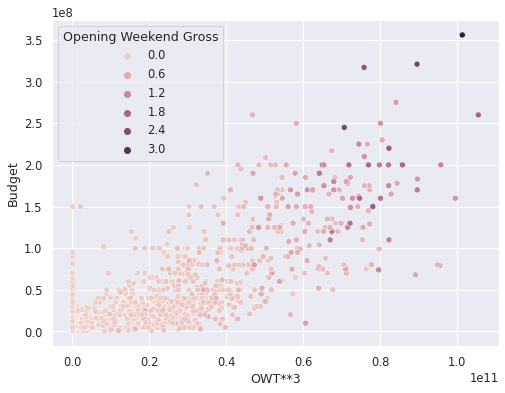

In [47]:
#Visualizing the transformed Opening Weekend THeatres column

plt.figure(figsize=(8,6))
sns.scatterplot(x='OWT**3', y = 'Budget', data=pd.concat([X_train,y_train],axis = 1), \
               hue = 'Opening Weekend Gross')


### Prelimnary Modelling

A simple regression modelling is carried out using all the features and cross validation for initial assessment

In [60]:
lm = LR()
lm.fit(X_train,y_train)
y_train_predict = lm.predict(X_train)
y_val_predict = lm.predict(X_val)
print(f"Train Score: R2:{r2_score(y_train,y_train_predict):,.2f}    MAE:{mae(y_train, y_train_predict):,.0f}.")
print(f"Val Score:  R2:{r2_score(y_val,y_val_predict):,.2f}    MAE:{mae(y_val, y_val_predict):,.0f}.")



Train Score: R2:0.77    MAE:6,922,980.
Val Score:  R2:0.73    MAE:6,405,504.



### Reducing the Feature Set
Using statsmodel, the features are evaluated for their significance. Based on the results, they are iteraitvely removed one by one to simplify the model without sacrificing predictability

In [54]:
def stats_model(X, y):
    """
    Func takes the X & y values and computes a linear regression model using OLS Stats Model package.
    
    Input
    X: Features Data
    y: Output Data
    
    Return:
    Fitted OLS Stats_Model
    """
    
    X = sm.add_constant(X)
    stats_model_ols = sm.OLS(y,X)
    stats_model_ols = stats_model_ols.fit()
    return stats_model_ols

stats_model(X_train,y_train).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Opening Weekend Gross   R-squared:                       0.768
Model:                               OLS   Adj. R-squared:                  0.764
Method:                    Least Squares   F-statistic:                     220.2
Date:                   Mon, 12 Oct 2020   Prob (F-statistic):               0.00
Time:                           18:54:32   Log-Likelihood:                -26568.
No. Observations:                   1487   AIC:                         5.318e+04
Df Residuals:                       1464   BIC:                         5.330e+04
Df Model:                             22                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -9.155e+06   4.25e+06     -2.156      0.031   -1.75e+07   -8.24e+05
Opening Weekend Theatres  -652.8245    675.644     -0.966      0.334   -1978.158     672.510
Budget                       0.0002      0.019      0.010      0.992      -0.036       0.037
Franchise                -4.167e+06   1.71e+06     -2.432      0.015   -7.53e+06   -8.06e+05
Brand                    -5.207e+06   1.63e+06     -3.186      0.001   -8.41e+06      -2e+06
All Audience              1.187e+07   4.13e+06      2.876      0.004    3.77e+06       2e+07
Adult Audience              1.2e+07   4.17e+06      2.877      0.004    3.82e+06    2.02e+07
Big_Studio               -1.415e+06   1.08e+06     -1.307      0.191   -3.54e+06    7.09e+05
Blockbuster_Season        -1.07e+06   4.65e+05     -2.300      0.022   -1.98e+06   -1.57e+05
Dump_Season               -1.31e+06   9.51e+05     -1.377      0.169   -3.18e+06    5.57e+05
Years Since              -3.055e+05   1.36e+05     -2.251      0.025   -5.72e+05   -3.93e+04
Action                   -8.335e+05   1.02e+06     -0.821      0.412   -2.82e+06    1.16e+06
Adventure                -4.002e+06   1.23e+06     -3.251      0.001   -6.42e+06   -1.59e+06
Comedy                   -2.106e+06   9.35e+05     -2.252      0.024   -3.94e+06   -2.71e+05
Drama                      1.79e+06    8.8e+05      2.034      0.042    6.38e+04    3.52e+06
Horror                     3.76e+06   1.36e+06      2.768      0.006     1.1e+06    6.42e+06
Romance                   8.292e+05   1.03e+06      0.803      0.422    -1.2e+06    2.85e+06
Thriller                 -3.892e+05   9.82e+05     -0.396      0.692   -2.32e+06    1.54e+06
High Fiction             -2.214e+06    1.1e+06     -2.021      0.044   -4.36e+06   -6.46e+04
Non-Fiction               6.404e+05   1.11e+06      0.578      0.564   -1.53e+06    2.82e+06
OWT**3                       0.0007   5.81e-05     11.894      0.000       0.001       0.001
Franch*Budget                0.2677      0.019     14.206      0.000       0.231       0.305
Brand*Budget                 0.1699      0.017      9.760      0.000       0.136       0.204
==============================================================================
Omnibus:                      881.361   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36617.565
Skew:                           2.116   Prob(JB):                         0.00
Kurtosis:                      26.939   Cond. No.                     5.47e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+11. This might

In [58]:
#Dropping columns on by one in the feature set below.

selected_cols = ['Adventure', 'Comedy','Drama','OWT**3','Franch*Budget', 'Brand*Budget','Years Since']

stats_model(X_train[selected_cols],y_train).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Opening Weekend Gross   R-squared:                       0.760
Model:                               OLS   Adj. R-squared:                  0.759
Method:                    Least Squares   F-statistic:                     670.0
Date:                   Mon, 12 Oct 2020   Prob (F-statistic):               0.00
Time:                           18:55:28   Log-Likelihood:                -26592.
No. Observations:                   1487   AIC:                         5.320e+04
Df Residuals:                       1479   BIC:                         5.324e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.361e+05   9.51e+05      0.669      0.504   -1.23e+06     2.5e+06
Adventure     -4.891e+06   1.11e+06     -4.402      0.000   -7.07e+06   -2.71e+06
Comedy        -2.235e+06   8.07e+05     -2.770      0.006   -3.82e+06   -6.53e+05
Drama          2.198e+06   8.23e+05      2.670      0.008    5.83e+05    3.81e+06
OWT**3            0.0006   2.58e-05     22.178      0.000       0.001       0.001
Franch*Budget     0.2577      0.012     21.562      0.000       0.234       0.281
Brand*Budget      0.1387      0.012     11.977      0.000       0.116       0.161
Years Since   -2.788e+05   1.34e+05     -2.085      0.037   -5.41e+05   -1.65e+04
==============================================================================
Omnibus:                      951.915   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45652.884
Skew:                           2.333   Prob(JB):                         0.00
Kurtosis:                      29.740   Cond. No.                     9.61e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.61e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

  
#### The columns in __selected_cols__ will be used for further analysis & final modelling ultimately.

----
### Polynomial Interactions with Ridge Regularization

The selected columns will be used to for polynomial interactions feature engineering. Additionally, since such an abundance of features are being created, Ridg Regression will be used to try to simplify the model.

In [81]:
#figuring out the best alpha to use for ridge regression

alpha_list = 10**(np.linspace(0.1,2,20))
error_val_mae = np.zeros(len(alpha_list))
error_val_r2 = np.zeros(len(alpha_list))
# error_train = np.zeros(len(alpha_list))

for i,current_alpha in enumerate(alpha_list):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('Poly', PolynomialFeatures(degree=2)),
             ('standardize', StandardScaler()), 
             ('Ridge', Ridge(alpha = current_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train[selected_cols], y_train)
    
    y_val_pred = pipe.predict(X_val[selected_cols])
    error_val_mae[i] = mae(y_val, y_val_pred)
    error_val_r2[i] = r2_score(y_val,y_val_pred)

Minimum MAE: 5186414.264460332 
        Maximum R2: 0.7740127993116964 
        Alpha Value for Min. MAE: 19.952623149688797


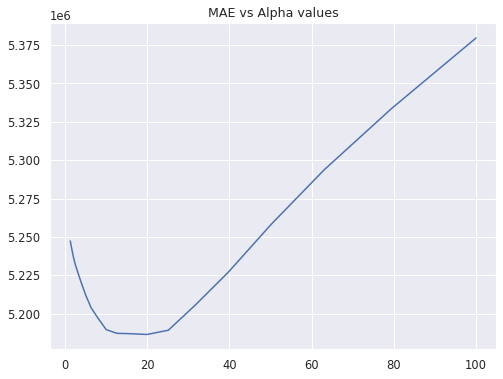

In [77]:
plt.figure(figsize=(8,6))
plt.plot(alpha_list,error_val_mae)
plt.title("MAE vs Alpha values")

print(f"Minimum MAE: {np.min(error_val_mae)} \n\
        Maximum R2: {np.max(error_val_r2)} \n\
        Alpha Value for Min. MAE: {alpha_list[np.argmin(error_val_mae)]}")

The above alpha value of 20 will be used under Cross-Validation to see how the higher order feature set with Ridge Regression compares to a simple Linear Regression with just the features in 'selected_cols'

In [82]:
def cross_val_kfold(X, y, splits = 5, alpha=1):
    """
    Function to do a kfold cross val based on the data, splits & alpha provided.
    Model does a default linear regression on the data as is.
    Additionally it engineers the features to 2nd order interactions,
    scales the values and does a Ridge Regularized Linear Regression.
    
    All scores are printed out for immediate evaluation.
    
    Inputs: X: Features Dataframe
            y: Target dataframe
            splits: integer # for splits
            alpha: regularization parameter
    
    Output: Tuple with five elements:
            0: Linear Regression model scores
            1: Linear Regression fitted model
            2: Ridge Regression model scores
            3: Ridge Regression fitted model
            4: Feature Names from Polynomial Transformation
    """
    
    kf = KFold(n_splits=splits, shuffle=True)
    cv_linear_model = {'r2':[],'mae':[]}
    cv_ridge_model = {'r2':[],'mae':[]}
    cv_lasso_model = {'r2':[],'mae':[]}

    X_tr_val, y_tr_val = np.array(X),np.array(y)

    for train_ind, val_ind in kf.split(X_tr_val,y_tr_val):
    
        X_train, y_train = X_tr_val[train_ind], y_tr_val[train_ind]
        X_val, y_val = X_tr_val[val_ind], y_tr_val[val_ind] 

        #simple linear regression
        lm = LR()
        lm_ridge = Ridge(alpha=alpha)
        lm_lasso = Lasso(alpha=alpha)
        
      
        lm.fit(X_train, y_train)
        y_val_pred = lm.predict(X_val)
        cv_linear_model['r2'].append(r2_score(y_val,y_val_pred))
        cv_linear_model['mae'].append(mae(y_val, y_val_pred))
        residuals = y_val - y_val_pred

        pf = PolynomialFeatures(degree=2, interaction_only=True)
        X_train_poly = pf.fit_transform(X_train)
        X_val_poly = pf.transform(X_val)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_val_scaled = scaler.transform(X_val_poly)

        lm_ridge.fit(X_train_scaled, y_train)
        y_val_pred = lm_ridge.predict(X_val_scaled)
        cv_ridge_model['r2'].append(r2_score(y_val,y_val_pred))
        cv_ridge_model['mae'].append(mae(y_val, y_val_pred))
    
   
    print(f"Average of Y Values In Validation Set: {np.mean(y_val):,.0f} \n")
    print(f"Simple Regression: \nMean MAE:\
    {np.mean(cv_linear_model['mae']):,.0f} +- {np.std(cv_linear_model['mae']):,.0f} \
    \nMean R2: {np.mean(cv_linear_model['r2']):,.3f} +- {np.std(cv_linear_model['r2']):,.3f}")
    
    print("---")
    print(f"Ridge Regression: \nMean MAE:\
    {np.mean(cv_ridge_model['mae']):,.0f} +- {np.std(cv_ridge_model['mae']):,.0f} \
    \nMean R2: {np.mean(cv_ridge_model['r2']):,.3f} +- {np.std(cv_ridge_model['r2']):,.3f}")
    print("*****************")
 
    return cv_linear_model, lm, cv_ridge_model, lm_ridge,X_val,y_val, pf.get_feature_names(X.columns)

b = cross_val_kfold(X_train_val[selected_cols],y_train_val,alpha=20)

Average of Y Values In Validation Set: 13,681,017 

Simple Regression: 
Mean MAE:    6,597,796 +- 261,729     
Mean R2: 0.752 +- 0.015
---
Ridge Regression: 
Mean MAE:    5,663,500 +- 290,215     
Mean R2: 0.799 +- 0.016
*****************


Based on the above analysis, it looks like Ridge regression on the model with increased features has a slightly higher R2 and a MAE that is lesser by 15% approximately.
But the difference is not particularly huge.  
A focus of this project is to get a simpler model where the feature set can be explained in a wholesome manner.  
Hence, the ridge model will be given secondary importance.

---
## Final Model

In [102]:
lm = LR()
lm.fit(X_train_val[selected_cols],y_train_val)
y_train_val_predict = lm.predict(X_train_val[selected_cols])
print(f"Train_Val Score:  R2:{r2_score(y_train_val,y_train_val_predict):,.2f}    MAE:{mae(y_train_val, y_train_val_predict):,.0f}\n")
print("Coeffecients:")
list(zip(selected_cols,lm.coef_))

Train_Val Score:  R2:0.76    MAE:6,523,058.

Coeffecients:


[('Adventure', -5550479.457595603),
 ('Comedy', -2243487.5196269252),
 ('Drama', 2196857.5528390636),
 ('OWT**3', 0.000596288125962019),
 ('Franch*Budget', 0.23940007100463845),
 ('Brand*Budget', 0.1267132178822976),
 ('Years Since', -293058.43004096433)]

#### Hold-out (Test) Dataset Prediction

In [103]:
y_test_pred = lm.predict(X_test[selected_cols])
residuals = y_test_pred - y_test
print(f"Test dataset Y Values Summary Stats: \n{y_test.describe()}")
print(f"Test Score:  R2:{r2_score(y_test,y_test_pred):,.2f}    MAE:{mae(y_test, y_test_pred):,.0f}.")


Test dataset Y Values Summary Stats: 
count    4.650000e+02
mean     1.320194e+07
std      2.462102e+07
min      7.400000e+01
25%      4.707400e+04
50%      2.702430e+06
75%      1.581502e+07
max      1.912711e+08
Name: Opening Weekend Gross, dtype: float64
Test Score:  R2:0.73    MAE:6,558,159.


**The prediction on the test dataset is quite close to the prediction on the training dataset; indicating the model is not overfit.**

In [120]:
sample_index

Int64Index([807, 1842, 1233, 916, 591], dtype='int64')

In [175]:
#Short listing 5 sample prediction rows for displaying in the presentation

sample_index = X_test.sample(5).index

sample_pred = lm.predict(X_test.loc[sample_index,selected_cols])

df_sample = pd.concat([sample_df.loc[sample_index,['Title','Opening Weekend Gross',*selected_cols]],pd.DataFrame(sample_pred,index=sample_index,columns=["Prediction"])],axis=1)

df_sample['error'] = df_sample['Prediction'] - df_sample['Opening Weekend Gross']
df_sample


,Title,Opening Weekend Gross,Adventure,Comedy,Drama,OWT**3,Franch*Budget,Brand*Budget,Years Since,Prediction,error
546,Magic Mike,39127170,0,1,1,25153757000,0.0,0.0,2,1.495617e+07,-2.417100e+07
1760,Justice League,93842239,1,0,0,66479344651,300000000.0,300000000.0,7,1.424630e+08,4.862073e+07
10,The Karate Kid,55665805,0,0,1,49148555247,40000000.0,0.0,0,4.166959e+07,-1.399622e+07
1307,Trainwreck,30097040,0,1,1,31494620312,0.0,0.0,5,1.785797e+07,-1.223907e+07
103,Our Family Wedding,7629862,0,1,0,4134520125,0.0,0.0,0,8.119048e+05,-6.817957e+06


### Visualization of Results

Results from the final model is visualized in various ways to get a wholesome understanding of the output.

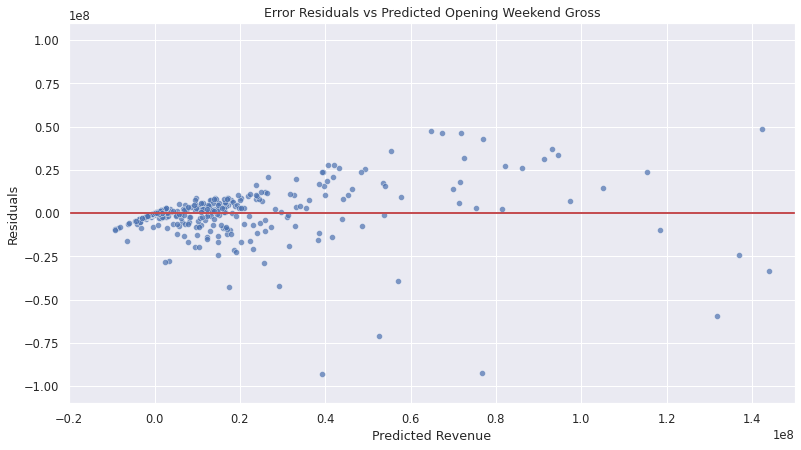

In [177]:
plt.figure(figsize=(13,7))

sns.scatterplot(x=y_test_pred,y=residuals,alpha=0.7)
plt.title("Error Residuals vs Predicted Opening Weekend Gross")
plt.ylabel('Residuals')
plt.xlabel("Predicted Revenue")
plt.plot((-.2e8,1.5e8),(0,0),c='r',linewidth=2)
plt.xlim(-.2e8,1.5e8)
plt.ylim(-1.1e8,1.1e8)
plt.savefig("Residuals plot.svg")

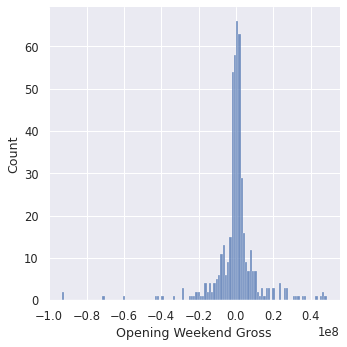

In [178]:
g=sns.displot(data=residuals)
# g.ax.set_xlim(-1*10**7,1*0**7)

Text(0, 0.5, 'Predicted Opening Weekend Gross')

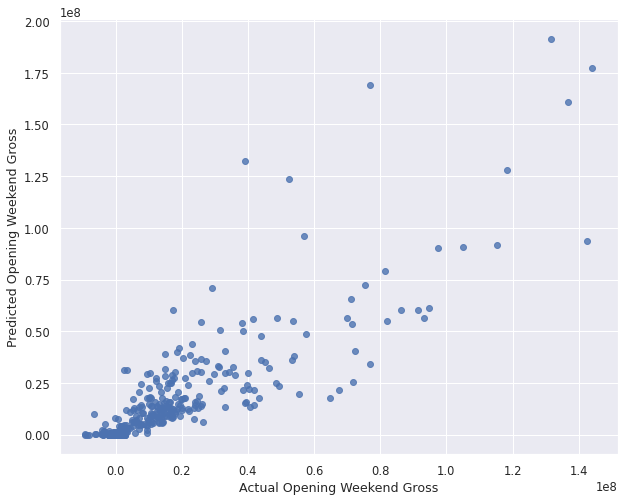

In [182]:
# Graph to plot y_preds vs y_actual with a line through the middle, indicating perfect capture of values.

plt.figure(figsize=(10,8))
plt.scatter(y_test_pred, y_test, alpha=.8)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
plt.xlabel("Actual Opening Weekend Gross")
plt.ylabel("Predicted Opening Weekend Gross")